<a href="https://colab.research.google.com/github/tesseract314/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/DS41SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [77]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 4.0MB/s 


In [79]:
!pip install eli5

    100% |████████████████████████████████| 102kB 4.6MB/s 


In [0]:
# imports
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
import matplotlib.pyplot as plt

### Part 1: Preprocessing

In [64]:
train.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0


In [65]:
train.shape

(51916, 17)

In [71]:
train.nunique()

DBA Name           17049
License #          21422
Facility Type        330
Risk                   4
City                  40
Zip                   87
Inspection Type       52
Violations            58
Latitude           13411
Longitude          13411
Fail                   2
dtype: int64

In [72]:
train.dtypes

DBA Name            object
License #          float64
Facility Type       object
Risk                object
City                object
Zip                float64
Inspection Type     object
Violations         float64
Latitude           float64
Longitude          float64
Fail                 int64
dtype: object

In [87]:
test.isnull().sum()

DBA Name           0
License #          0
Facility Type      0
Risk               0
City               0
Zip                0
Inspection Type    0
Latitude           0
Longitude          0
Fail               0
dtype: int64

In [0]:
# wrangle data
def wrangle(X):
  X = X.copy()
  
  # Change NaN to 'Unknown' for Facility Type
  X['Facility Type'] = X['Facility Type'].fillna('Unknown')
  
  # Fill NaN License # with -1
  X['License #'] = X['License #'].fillna(-1)
  
  # Fill NaN Risk with 'Unknown'
  X['Risk'] = X['Risk'].fillna('Unknown')
  
  # Fill NaN lat and long with mean
  X['Latitude'] = X['Latitude'].fillna(X['Latitude'].mean())
  X['Longitude'] = X['Longitude'].fillna(X['Longitude'].mean())
  
  # Fill NaN Inspection Type with 'Unknown'
  X['Inspection Type'] = X['Inspection Type'].fillna('Unknown')
  
  # Fill NaN City with 'Unknown'
  X['City'] = X['City'].fillna('Unknown')
  
  # Fill NaN Zip with -1
  X['Zip'] = X['Zip'].fillna(-1)
  
  # Drop leaky column
  X = X.drop(columns='Violations')
  
  
  # Drop high cardinality and unnecessary columns
  X = X.drop(columns=['Inspection ID', 'AKA Name', 'Address', 'State', 
                      'Inspection Date', 'Location'])
  
  return X

In [0]:
# apply wrangle function
train = wrangle(train)
test = wrangle(test)

In [0]:
# The data leakage was coming from the Violations feature. This column heavily
# indicates whether or not the business failed the inspection. Because the goal is to
# predict pass/fail, we wouldn't know what the violations are at the time of prediction.

### Part 2: Modeling

In [88]:
# See majority class
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [0]:
# Split into independent and dependent variables
X_train = train.drop(columns='Fail')
y_train = train['Fail']

X_test = test.drop(columns='Fail')
y_test = test['Fail']

In [90]:
# Make pipeline and see crossval scores

pipe = make_pipeline(
    ce.OrdinalEncoder(),
    GradientBoostingClassifier(n_estimators=400)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')

array([0.6893133 , 0.67773963, 0.68435491, 0.68757829, 0.6871228 ])

In [0]:
# Tune model
pipe2 = make_pipeline(
    ce.OrdinalEncoder(),
    GradientBoostingClassifier(n_estimators=400, max_depth=4)
)

In [101]:
# Prediction with test data
pipe2.fit(X_train, y_train)
y_pred_proba = pipe2.predict_proba(X_test)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7036300091999605


### Part 3: Visualization

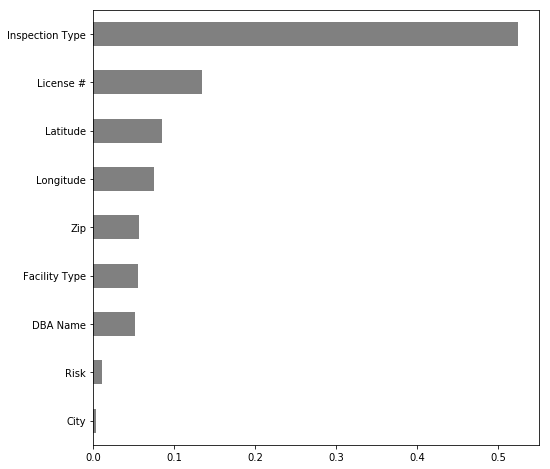

In [97]:
# Feature Importances

def show_feature_importances(pipe, X, y, estimator_name='gradientboostingclassifier',
                             n=X_train.shape[1], figsize=(8, 8)):
  # Fit model
  pipe.fit(X, y)
  
  # Variable with feature importance from pipe
  importances = pd.Series(pipe.named_steps[estimator_name].feature_importances_, X.columns)
  
  # Sort importances
  sort = importances.sort_values(ascending=False)[:n]
  
  plt.figure(figsize=figsize)
  sort.sort_values().plot.barh(color='grey')
  
show_feature_importances(pipe, X_train, y_train)

In [99]:
# Permutation Importances

# Encode
encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

# Model
model = GradientBoostingClassifier(n_estimators=400)

# Fit model
model.fit(X_train_transformed, y_train)
# Create permuter with model
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
# Fit permuter
permuter.fit(X_train_transformed, y_train)

# Show weights
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())


Weight,Feature
0.1709 ± 0.0000,Inspection Type
0.0337 ± 0.0000,Longitude
0.0329 ± 0.0000,Latitude
0.0273 ± 0.0000,License #
0.0179 ± 0.0000,Zip
0.0148 ± 0.0000,Facility Type
0.0146 ± 0.0000,DBA Name
0.0041 ± 0.0000,Risk
0.0008 ± 0.0000,City
